<a href="https://colab.research.google.com/github/jlgrons/CELEHS-DSinA/blob/main/Introduction_to_neural_networks_Soln.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import keras
keras.__version__

'2.8.0'

# A First Look at Neural Networks

This notebook is largely based on the material from [François Chollet](https://github.com/fchollet/deep-learning-with-python-notebooks), he has a great collection of deep learning tutorials, which contain notebooks from the book [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff).


----
##Background
After our brief review of the theory, let's take a look at a concrete example of a neural network. We will be using Python's Keras library to program a neural network to learn how to classify handwritten digit images. If you have any questions or comments we will be around to guide you!

The database consists of 28x28x3 pixel RGB photos in a colon pathology dataset. We want to classify the respective categories that the images belong to [MedMNIST](https://medmnist.com/).

---
##Understanding the Data

First we will import the data from the MedMNIST database:

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import IPython.core.display
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn import *
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into train

We are going to consolidate the data and ensure that they have the right formality for the NN framework.

In [ ]:
tf.random.set_seed(12345)

In [ ]:
train_images = train_dataset.imgs
test_images = test_dataset.imgs

In [ ]:
train_labels = train_dataset.labels
test_labels = test_dataset.labels

As suspected, `train_images` and `train_labels` will be used so that the neural network learns to abstract the feature from their different representations. The model will be tested with `test_images` and `test_labels`. There is only one label per image.

The following code chunks give us some examples on how the data should look like.

###Training Sample:

Each image should have the format of 28x28x3.

In [ ]:
# shape of the training data
print('Training sample dimensions: ' + str(train_images.shape))

Training sample dimensions: (89996, 28, 28, 3)


One label ranging from 0 to 8 is assigned for each image.

In [ ]:
# size of the training data
print('Training sample size: ' + str(train_labels.size))

Training sample size: 89996


Each image is represented by a 28x28x3 3D array, representing the RGB colors for a 28x28 image at each pixel.

In [ ]:
#getting the entire matrix of a single image
train_images[0]

array([[[220, 208, 227],
        [219, 207, 227],
        [220, 207, 227],
        ...,
        [220, 208, 227],
        [219, 207, 227],
        [221, 208, 227]],

       [[218, 206, 226],
        [220, 207, 226],
        [219, 206, 226],
        ...,
        [197, 177, 202],
        [192, 172, 197],
        [190, 168, 195]],

       [[220, 208, 226],
        [220, 207, 226],
        [219, 205, 225],
        ...,
        [208, 191, 213],
        [207, 192, 213],
        [209, 194, 216]],

       ...,

       [[218, 205, 225],
        [217, 201, 222],
        [221, 208, 227],
        ...,
        [221, 208, 227],
        [220, 208, 227],
        [221, 209, 227]],

       [[213, 192, 218],
        [217, 200, 222],
        [221, 208, 227],
        ...,
        [221, 208, 227],
        [221, 209, 227],
        [221, 208, 227]],

       [[215, 195, 220],
        [220, 207, 226],
        [221, 208, 227],
        ...,
        [220, 208, 227],
        [221, 208, 227],
        [222, 209, 228]]

Each image shall represent a patch of body tissue. Specifically, the following image represents adipose (fat) tissue and has label 0.

Label: [0]
The actual image:


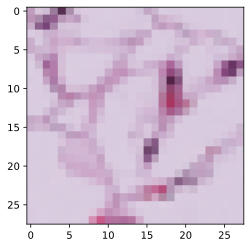

In [ ]:
plt.ion()
print('Label: ' + str(train_labels[12345]))
print('The actual image:')
plt.imshow(train_images[12345])
plt.show()

The labels are numbers representing categories that the images would be expected to belong to.

In [ ]:
print('This is what the vector of labels look like:') 
train_labels

This is what the vector of labels look like:


array([[0],
       [4],
       [7],
       ...,
       [2],
       [0],
       [2]], dtype=uint8)

### Testing Sample:
Print the following characteristics of the test sample object. The testing dataset has 7180 images in total.

In [ ]:
########## STUDENT WORK ##########
print('Test sample dimensions:'  + str(test_images.shape))

Test sample dimensions:(7180, 28, 28, 3)


In [ ]:
########## STUDENT WORK ##########
print('Test sample size: ' + str(test_labels.size))

Test sample size: 7180


Show one plot of actual testing image:
Label: [8]
The actual image:


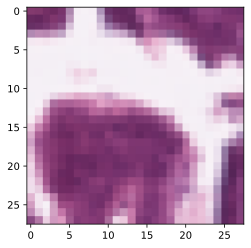

In [ ]:
########## STUDENT WORK ##########
# colorectal adenocarcinoma epithelium (cancer tissue)
print('Show one plot of actual testing image:')

print('Label: ' + str(test_labels[123]))
print('The actual image:')
plt.imshow(test_images[123])
plt.show()

You are now ready to start playing with machine learning.

---
##Building Your First Neural Network

You will first design the structure of the neural network (NN), in ML lingo: the NN's "architecture". Then you will show use the training data, both the images and it's labels showing the digits, to show your network what each digit looks like. The network will learn the relevant patterns to associate the images with the respective labels, abstracting the important features that distinguish each digit. Finally, you will put the network to the test with images it has never "seen" and will see if it is able to label these correctly.

In [ ]:
from keras import models
from keras import layers

As seen in the slides, the network's architecture is composed of layers, which receive information and process it into something more useful to pass on to the next block. The majority of the process of building networks consists of stacking these simple blocks that together create a process to refine the data.

---
###Construction
Construct a sequence of "densely connected" neurons ( see [`Conv2D`](https://keras.io/api/layers/convolution_layers/convolution2d/) and [`Dense`](https://keras.io/api/layers/core_layers/dense/)).

Consider a 3-layer model. Make the first two layers 2D convolutional layers with 32 and 64 neurons/units respectively, both with `relu` activation function.

The final layer must have an output of 9 units, the elements of vector of probabilities (which add up to 1). The first entry in the vector will have the probability that the images belongs to category '0' (Adipose tissue), and so on up to the $9^{th}$ entry. What is the necessary activation function to achieve this?

Consider taking a took at the documentation on [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).



In [ ]:
########## STUDENT WORK ##########
#hint: note input shape of data is 28x28x3 from above
#hint: make sure you are using layers.(functionname)

net = models.Sequential()
net.add(layers.Conv2D(filters = 32, kernel_size = (3,3),
                      input_shape = (28,28,3), activation = "relu"))
net.add(layers.MaxPooling2D(pool_size = (2,2)))
net.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation = "relu"))
net.add(layers.MaxPooling2D(pool_size = (2,2)))
net.add(layers.Flatten())
net.add(layers.Dropout(0.5))
net.add(layers.Dense(9, activation = "softmax")) #because It's a multi-classification problem

The following code chunk checks the model layout. Just make sure that the input looks like the output, then the model should be reasonable. A neural network model should allow for some flexibility, and things may turn out to be better when the model is tweaked a little bit.

In [ ]:
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dropout (Dropout)           (None, 1600)              0

---
In order to train the neural network, we need to choose 3 more components for the compilation process:

* **The loss function**: as we saw the loss function for the case where there are only 2 classes in the slides, we can generalize the concept for $n$ classes, this function is called categorical cross-entropy ([`categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy)).

* **The optimization algorithm**: to minimize the loss function, this time we will use [`rmsprop`](https://keras.io/api/optimizers/rmsprop/) instead of stochastic gradient descent.

* **Performance metrics**: to measure how well we are classifying images we are going to monitor the fraction of correctly classified images, there are many other metrics that you can explore, the options change depending if what we want to predict is continuous or discrete, binary or categorical.

Play around with these three components to see if you can improve benchmark performance!


In [ ]:
########## STUDENT WORK ##########
#hint: see above for optimizer function

# from keras.optimizers import SGD 
net.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

---
Before beginning the training you will process the images. The matrices need to be converted into vectors as this is what the network takes as inputs. Additionally, you will normalize the RGB level so that they are in the interval [0,1]. Currently there are ranging between [0,255], and you need to convert each one to a "flat" vector.

This next cell that normalizes the data was obtained from [here](https://victorzhou.com/blog/keras-neural-network-tutorial/).

In [ ]:
# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Flatten the images.
# train_images = train_images.reshape((-1, 2352))
# test_images = test_images.reshape((-1, 2352))

You should also change the labels: each entry with a digit shall be transformed into a vector of zeros size 9, however in the place of the corresponding digit, it should have the number one. Lets see an example:

In [ ]:
from tensorflow.keras.utils import to_categorical
print('For example the list of labels with digit 3 and 9' +
      ' will turn into the list of vectors: \n'+ str(to_categorical([3,9])))

For example the list of labels with digit 3 and 9 will turn into the list of vectors: 
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
# one-hot encoding the labels for vectorization
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

---
###Training pt.1
We are ready to begin the training, with `Keras`, this is done with the `fit` function, we specify how many samples we simultaneously pass to the neural network to calculate the gradient with `batch_size`, and how many times we pass through all the training sample with `epochs`. The code may run for a while but would not take a hopelessly long period of time. The following code chunk takes ~3min to run under my implementation.

In [ ]:
history = net.fit(train_images, train_labels, epochs = 20, batch_size = 128)

Epoch 1/20
704/704 [==============================] - 9s 6ms/step - loss: 1.1770 - accuracy: 0.5590
Epoch 2/20
704/704 [==============================] - 4s 5ms/step - loss: 0.8557 - accuracy: 0.6884
Epoch 3/20
704/704 [==============================] - 4s 5ms/step - loss: 0.7346 - accuracy: 0.7361
Epoch 4/20
704/704 [==============================] - 4s 5ms/step - loss: 0.6580 - accuracy: 0.7641
Epoch 5/20
704/704 [==============================] - 4s 5ms/step - loss: 0.5993 - accuracy: 0.7861
Epoch 6/20
704/704 [==============================] - 4s 5ms/step - loss: 0.5543 - accuracy: 0.8040
Epoch 7/20
704/704 [==============================] - 4s 5ms/step - loss: 0.5175 - accuracy: 0.8177
Epoch 8/20
704/704 [==============================] - 4s 5ms/step - loss: 0.4890 - accuracy: 0.8284
Epoch 9/20
704/704 [==============================] - 4s 5ms/step - loss: 0.4626 - accuracy: 0.8386
Epoch 10/20
704/704 [==============================] - 4s 5ms/step - loss: 0.4389 - accuracy: 0.8470

---
###Results pt.1
Let's visualize the training results.

In [ ]:
# the training results in the formation of a dictionary
history.history.keys() #view the keys

dict_keys(['loss', 'accuracy'])

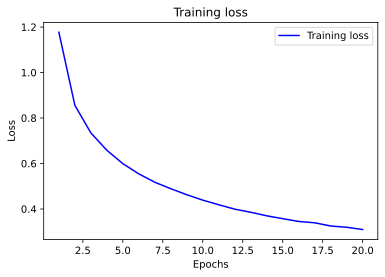

In [ ]:
import matplotlib.pyplot as plt

# history is a variable that stores the results of the trained model
# .history is an dictionary attribute of the results of the trained model 
# the history dictionary contains the losses and accuracy levels per epoch

########## STUDENT WORK ##########
# put in one of the history dictionary keys in the brackets
loss = history.history['loss']

epochs = range(1,len(loss)+1)

# Time to plot the graph
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

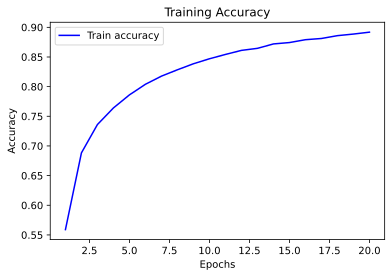

In [ ]:
########## STUDENT WORK ##########
# put in one of the history dictionary keys in the brackets
accuracy = history.history['accuracy']

plt.plot(epochs, accuracy, 'b', label ="Train accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

The two metrics that appear above are the value of the loss function: `loss` (we want it to be as small as possible) and the fraction of correctly classified images (accuracy): `acc` (we want it to be as high as possible). 

In the plots that appears above, we hope to observe a trend of decreasing training loss and increasing training accuracy all the way in our training.

Now lets check out the performance in the images that our network has not seen:

In [ ]:
#This prints out training accuracy
train_loss, train_acc = net.evaluate(train_images, train_labels)

2813/2813 [==============================] - 8s 3ms/step - loss: 0.3928 - accuracy: 0.8621


In [ ]:
print("Train accuracy: {0:.1%}".format(train_acc))

Train accuracy: 86.2%


In [ ]:
# This looks at test accuracy
test_loss, test_acc = net.evaluate(test_images, test_labels)

225/225 [==============================] - 1s 4ms/step - loss: 0.6829 - accuracy: 0.8411


In [ ]:
print("Test accuracy: {0:.1%}".format(test_acc))

Test accuracy: 84.1%


Our test set accuracy turns out to be  around 85% -- that is quite a bit lower than the training set accuracy. This gap between training accuracy and test accuracy is an example of "overfitting", the fact that machine learning models tend to perform worse on new data than on their training data. Overfitting will be a central topic in training the self-driving cars.

This concludes our very first example -- you just saw how we could build and a train a neural network to classify medical images, in no more than 30 lines of Python code!

---
### Training pt.2 (OPTIONAL)


TRAINING 2: In these next few cells, we get to retrain the model using a different optimizer to see how it performs.

In [ ]:
# I added this for the sake of it
sgd = tf.keras.optimizers.SGD(lr=1, decay=1e-6, momentum=0.9, nesterov=False)

########## STUDENT WORK ##########
# put in the specified optimizer
# put in the loss function that handles multi-class classification
net.compile(optimizer='sgd',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = net.fit(train_images, train_labels, epochs=20, batch_size=128)
history #view the keys

Epoch 1/20
704/704 [==============================] - 4s 5ms/step - loss: 1.8553 - accuracy: 0.3847
Epoch 2/20
704/704 [==============================] - 3s 5ms/step - loss: 1.2682 - accuracy: 0.5584
Epoch 3/20
704/704 [==============================] - 3s 5ms/step - loss: 0.6035 - accuracy: 0.7933
Epoch 4/20
704/704 [==============================] - 3s 5ms/step - loss: 0.4291 - accuracy: 0.8495
Epoch 5/20
704/704 [==============================] - 3s 5ms/step - loss: 0.3969 - accuracy: 0.8612
Epoch 6/20
704/704 [==============================] - 3s 5ms/step - loss: 0.3623 - accuracy: 0.8735
Epoch 7/20
704/704 [==============================] - 3s 5ms/step - loss: 0.3436 - accuracy: 0.8802
Epoch 8/20
704/704 [==============================] - 3s 5ms/step - loss: 0.3531 - accuracy: 0.8771
Epoch 9/20
704/704 [==============================] - 3s 5ms/step - loss: 0.3730 - accuracy: 0.8718
Epoch 10/20
704/704 [==============================] - 3s 5ms/step - loss: 0.3199 - accuracy: 0.8871

We could check the results via the following code chunks.

In [ ]:
#This prints out training accuracy
train_loss, train_acc = net.evaluate(train_images, train_labels)

2813/2813 [==============================] - 8s 3ms/step - loss: 0.5101 - accuracy: 0.8301


In [ ]:
print("Train accuracy via SGD: {0:.1%}".format(train_acc))

Train accuracy via SGD: 83.0%


In [ ]:
# Make a comparison
test_loss, test_acc = net.evaluate(test_images, test_labels)

225/225 [==============================] - 1s 3ms/step - loss: 0.7881 - accuracy: 0.7935


In [ ]:
print("Test accuracy via SGD: {0:.1%}".format(test_acc))

Test accuracy via SGD: 79.3%


The result shows that the model fitted by SGD would give a rather similar testing accuracy as the model fitted by Root Mean Squared Propagation (rmsprop) that we used before. There could be some difference since we are actually using a slightly different model.

---
###Results pt.2 (OPTIONAL)

We could take a look at the training loss and the training accuracy of the model fitted by SGD via the following code chunks.

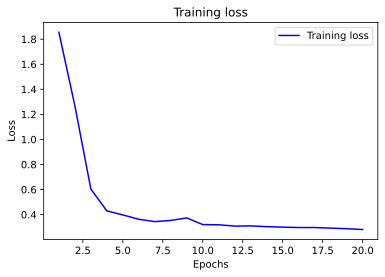

In [ ]:
import matplotlib.pyplot as plt

# history is a variable that stores the results of the trained model
# .history is an dictionary attribute of the results of the trained model 
# the history dictionary contains the losses and accuracy levels per epoch

########## STUDENT WORK ##########
# put in one of the history dictionary keys in the brackets
loss = history.history['loss']

epochs = range(1,len(loss)+1)

# Time to plot the graph
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.title("Training loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()

plt.show()

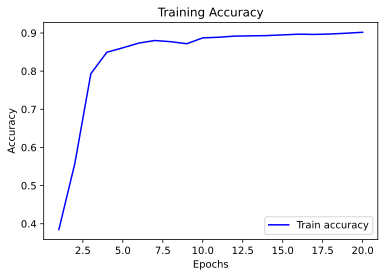

In [ ]:
########## STUDENT WORK ##########
# put in one of the history dictionary keys in the brackets
accuracy = history.history['accuracy']

# This is the plotting code
plt.plot(epochs, accuracy, 'b', label ="Train accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()